# Librerias

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import c_
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ui import UI
from data_preprocess import DataPreprocess
from neural_network import NeuralNetwork

# Codigo de entrenamiento

In [15]:
def train(epochs, mid_layer_neurons, learning_rate):
    iterations = epochs # 5000
    dimensions = [4, mid_layer_neurons, 1] # 10
    min_valid_loss = np.inf
    saved_iteration_values = []
    model = NeuralNetwork(dimensions, learning_rate)
    print("Entrenando ...")
    for i in tqdm(range(1, iterations+1)):
        model.train(X_train, y_train.values)
        train_loss= NeuralNetwork.MSE(model.test(X_train), y_train.values)
        valid_loss= NeuralNetwork.MSE(model.test(X_valid), y_valid.values)
        if valid_loss < min_valid_loss:
            best_params = model.parameters
            min_valid_loss = valid_loss
            with open('best_params.pickle', 'wb') as file:
                pickle.dump(best_params, file)
        if i % 100 ==0:
            #print('Iteración: {} ... Train error: {} ... Validation error: {}'.format(i, round(train_loss, 4), round(valid_loss,4)))
            saved_iteration_values.append([i, round(train_loss, 4), round(valid_loss,4)])
    x_axis = [data_point[0] for data_point in saved_iteration_values]
    y_axis_train = [data_point[1] for data_point in saved_iteration_values]
    y_axis_validation = [data_point[2] for data_point in saved_iteration_values]
    return model, x_axis, y_axis_train, y_axis_validation

def plot(x_axis, y_axis_train, y_axis_validation):
    # Plot aprendizaje.
    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis_train, "r--", label="entrenamiento")
    ax.plot(x_axis, y_axis_validation, "b--", label="validacion")
    ax.set(xlabel="Epocas", ylabel="Tasa de aprendizaje",
           title="Aprendizaje red neuronal")
    ax.grid()
    ax.legend(loc="upper right")
    # Diferencia tasa aprendizaje.
    fig, ax2 = plt.subplots()
    y_diff_train_valid = [y_train-y_valid for y_train, y_valid in zip(y_axis_train, y_axis_validation)]
    ax2.plot(x_axis, y_diff_train_valid, "p--", label="entrenamiento")
    ax2.set(xlabel="Epocas", ylabel="Diferencia aprendizaje entrenamiento y validacion",
           title="Aprendizaje red neuronal")
    ax2.grid()
    ax2.legend(loc="upper right")
    
def plot_predictions(df_test=None):
    # Plot aprendizaje.
    fig, ax3 = plt.subplots()
    x_axis = [x for x in range(len(df_test["%carga_real"].to_list()))]
    ax3.plot(x_axis, df_test["%carga_real"].to_list(), "p--", label="%carga real")
    ax3.plot(x_axis, df_test["%carga_predecido"].to_list(), "p--", label="%carga predecida")    
    ax3.set(xlabel="Dato", ylabel="% carga",
           title="Diferencia entre % carga real y predecida")
    ax3.grid()
    ax3.legend(loc="upper right")

# Carga de los datos

In [4]:
# Cargar los datos.
filepath = os.path.join(os.getcwd(), "INPUT_OUTPUT_CORREGIDO.xlsx")
df_input = DataPreprocess.load_data_from_excel(filepath=filepath, sheetname="INPUT")
df_output = DataPreprocess.load_data_from_excel(filepath=filepath, sheetname="OUTPUT")

In [5]:
# Preprocesar los datos.
df_input.drop("PSTO", axis=1, inplace=True)

In [6]:
# Split dataset.
X_train, X_test, y_train, y_test = DataPreprocess.split_dataset(data_input=df_input, data_output=df_output, test_size=0.2)
X_valid, X_test, y_valid, y_test = DataPreprocess.split_dataset(data_input=X_test, data_output=y_test, test_size=0.25)
X_train, X_valid, X_test = DataPreprocess.preprocessing_data(X_train, X_valid, X_test)

# Entrenamiento

In [7]:
epochs_slider = UI.create_int_slider(value=5000, min=0, max=10000, step=100, name="Epocas")
learning_rate_slider = UI.create_float_slider(value=0.08, min=0, max=1, step=0.01, name="Aprendizaje")
mid_layer_neurons_slider = UI.create_int_slider(value=10, min=0, max=20, step=1, name="Neuronas")
display(epochs_slider)
display(learning_rate_slider)
display(mid_layer_neurons_slider)

IntSlider(value=5000, continuous_update=False, description='Epocas: ', max=10000, step=100)

FloatSlider(value=0.08, continuous_update=False, description='Aprendizaje: ', max=1.0, readout_format='.4f', s…

IntSlider(value=10, continuous_update=False, description='Neuronas: ', max=20)

In [8]:
model, x_axis, y_axis_train, y_axis_validation = train(int(epochs_slider.value), 
                                                  mid_layer_neurons_slider.value, 
                                                  float(learning_rate_slider.value),)

  1%|          | 60/5000 [00:00<00:08, 593.16it/s]

Entrenando ...


100%|██████████| 5000/5000 [00:11<00:00, 428.28it/s]


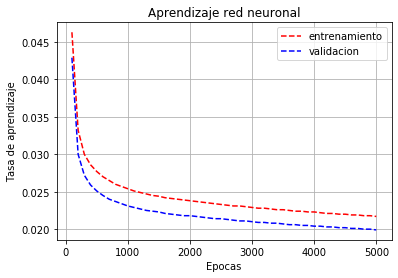

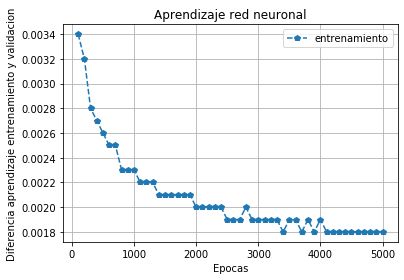

In [9]:
plot(x_axis, y_axis_train, y_axis_validation)
plt.show()

# Prueba sobre el dataset de valores de testeo

In [10]:
with open('best_params.pickle', 'rb') as file:
    best_params = pickle.load(file)
model.parameters = best_params
test_pred = model.test(X_test)
print("Porcentaje de error sobre el test dataset: ", round(NeuralNetwork.MSE(test_pred, y_test.values), 5))

Porcentaje de error sobre el test dataset:  0.02444


In [11]:
df_test = pd.DataFrame(data=X_test.copy(), columns=["KVA_TOT", "No", "kWh", "Cluster"])
df_test["%carga_real"] = y_test["%carga"].to_list()
df_test["%carga_predecido"] = [each[0] for each in test_pred]
df_test["error_%carga"] = [abs(real-predecido) for real, predecido in zip(df_test["%carga_real"].to_list(), df_test["%carga_predecido"].to_list())]
df_test.head()

,KVA_TOT,No,kWh,Cluster,%carga_real,%carga_predecido,error_%carga
0,-0.083327,0.601417,-0.034511,-0.169997,0.344848,0.153693,0.191155
1,1.005084,-0.788690,-0.077268,5.882446,1.000000,0.827566,0.172434
2,0.227647,1.032830,0.000107,-0.169997,0.148751,0.103756,0.044995
3,0.072160,0.649352,-0.072116,-0.169997,0.134299,0.148149,0.013850
4,-0.238815,-0.069669,-0.074074,-0.169997,0.385417,0.303233,0.082183


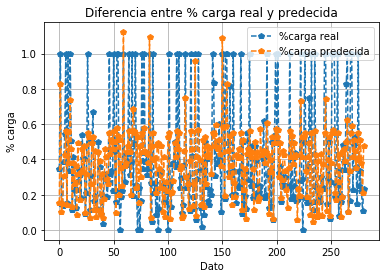

In [12]:
plot_predictions(df_test=df_test)
plt.show()

# Predecir valor

In [13]:
KVA_TOT = UI.create_float_text(value=1.0, name="KVA_TOT")
No = UI.create_float_text(value=1.0, name="No")
kWh = UI.create_float_text(value=1.0, name="kWh")
Cluster = UI.create_float_text(value=1.0, name="Cluster")
display(KVA_TOT)
display(No)
display(kWh)
display(Cluster)

FloatText(value=1.0, description='KVA_TOT: ')

FloatText(value=1.0, description='No: ')

FloatText(value=1.0, description='kWh: ')

FloatText(value=1.0, description='Cluster: ')

In [14]:
#print(KVA_TOT.value, No.value, kWh.value, Cluster.value)
scaler = StandardScaler()
null = scaler.fit_transform(df_input)
x_test_predict = np.array([KVA_TOT.value, No.value, kWh.value, Cluster.value]).reshape(1,4)
x_test_predict = scaler.transform(x_test_predict)
#print(x_test_predict)
test_pred = model.test(x_test_predict)
print("Valor predecido: ", test_pred[0][0])

Valor predecido:  0.520976739498371
